# Deep Learning Workflow

Get data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from copy import deepcopy
import pickle

from keras.models import load_model
from keras.layers import Input, Flatten, Dense
from keras.models import Model

from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from tensorflow.nn import softmax

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train, x_val = tf.split(x_train, [50000, 10000], axis=0)
y_train, y_val = tf.split(y_train, [50000, 10000], axis=0)

batch_size = 10000

train_size = x_train.shape[0]
val_size = x_val.shape[0]
img_length = x_train.shape[1] * x_train.shape[2]
img_shape1 = x_train.shape[1]
img_shape2 = x_train.shape[2]
num_classes = 10

x_train = x_train/126
x_val = x_val/126
x_test = x_test/126
y_train = tf.one_hot(y_train, num_classes)/1
y_val = tf.one_hot(y_val, num_classes)/1
y_test = tf.one_hot(y_test, num_classes)/1

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
#val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)

path = 'results/'


Using TensorFlow backend.


Define, train, and evaluate a model

In [ ]:
x_in = Input(shape=(x_train.shape[1],x_train.shape[2]))
x = Flatten()(x_in)
x = Dense(200, activation='relu')(x)
x = Dense(200, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(x_in, x)

In [ ]:
model.compile(loss=CategoricalCrossentropy(from_logits=False), optimizer=SGD(lr=1e-3, momentum=0.95), metrics=CategoricalAccuracy())

model.fit(x_train, y_train, batch_size=batch_size, epochs=200, verbose=1)

In [ ]:
model.evaluate(x_val, y_val)

313/313 [==============================] - 1s 2ms/step - loss: 0.1013 - categorical_accuracy: 0.9787


[0.10134784132242203, 0.9786999821662903]

In [ ]:
# model.save(path+'model_xxx/')

In [ ]:
# model = load_model(path+'model_1200_1200_10_relu/')

# Data Perturbation

**Main section for performing data perturbation**

In [121]:
def objective(r, model, x, y, c=0.5, bayesian=False):
    norm = tf.reduce_mean(tf.norm(r, axis=(1,2)))
    perturbed_img = x + r
    y_pred = model(perturbed_img)
    loss_value = 1/c*CategoricalCrossentropy()(y, y_pred)

    return (norm + loss_value)

def perturb_data(model):
    optimizer = RMSprop(lr=0.01)
    r_matrices = np.zeros((val_size, num_classes, img_shape1, img_shape2))
    r_norms = np.zeros((val_size, num_classes))

    for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
        for k in range(num_classes):
            print('Class ' + str(k))
            
            r = tf.Variable(np.zeros((x_batch_val.shape[0], img_shape1, img_shape2))+2e-2, 
                            constraint = lambda x: tf.clip_by_value(x, 1e-6, 2.03 - x_batch_val),
                            dtype=tf.float32, name='r')
            y_fake = np.zeros((x_batch_val.shape[0], num_classes))
            y_fake[:, k] = 1.
        
            epochs = 4000
            for epoch in range(epochs):
                with tf.GradientTape() as tape:
                    loss_value = objective(r, model, x_batch_val, y_fake, c=2*(epoch+1)/epochs)
                    grads = tape.gradient(loss_value, [r])
                optimizer.apply_gradients(zip(grads, [r]))

                # y_pred = softmax(model(x_batch_val+r), axis=1)
                # y_pred = y_pred.numpy()

                if epoch % 100 == 0:
                    print('Epoch ' + str(epoch))
                    # count = 0
                    # norm_count = 0
                    # for i in range(x_batch_val.shape[0]):
                    #     if np.argmax(y_pred[i,:]) == k and np.argmax(y_batch_val[i,:]) != k:
                    #         count += 1
                    #         norm_count += tf.norm(r[i]).numpy()
                    # print(' -- Finding rate: ' + str(count/x_batch_val.shape[0]))
                    # print(' -- Norm of r: ' + str(norm_count/x_batch_val.shape[0]))
            
            y_pred = model(x_batch_val+r).numpy()
            
            for j in range(x_batch_val.shape[0]):
                i = int(step * batch_size + j)
                if np.argmax(y_pred[i,:]) == k and np.argmax(y_batch_val[i,:]) != k:
                    r_norms[i,k] = tf.norm(r[i]).numpy()
                    r_matrices[i,k,:,:] = r[i].numpy()
                else:
                    r_norms[i,k] = 1e6
                # print(r_norms[i,:])
    return r_norms, r_matrices
        

Run

In [205]:
model_names = ['model_10','model_10_l2_3','model_10_l2_2','model_10_l2_1',
               'model_100_100_10_relu','model_100_100_10_relu_l2_3','model_100_100_10_relu_l2_2','model_100_100_10_relu_l2_1',
               'model_200_200_10_relu','model_200_200_10_relu_l2_3','model_200_200_10_relu_l2_2','model_200_200_10_relu_l2_1',
               'model_1200_1200_10_relu','model_1200_1200_10_relu_l2_3','model_1200_1200_10_relu_l2_2','model_1200_1200_10_relu_l2_1']

bayes_names = ['bayes_30_0','bayes_10_0','bayes_4_0','bayes_3_0','bayes_2_5','bayes_2_0','bayes_1_5']

In [ ]:
for i in range(len(model_names)):
    name = model_names[i]
    model = load_model(path+'models/'+name+'/')
    r_norms, r_matrices = perturb_data(model)
    with open(path+'r_matrices/r_matrices_' + name + '.pickle', 'wb') as handle:
        pickle.dump(r_matrices, handle, protocol=pickle.HIGHEST_PROTOCOL)


Get saved data

In [138]:
import pandas as pd

r_matrices_16 = np.zeros((16, val_size, num_classes, img_shape1, img_shape2))
models = []

for i in range(len(model_names)):
    name = model_names[i]
    models.append(load_model(path + 'models/' + name + '/'))
    r_matrices_16[i] = pd.read_pickle(path+'r_matrices/r_matrices_' + name + '.pickle')
    print(i)

with open(path+'r_matrices/r_matrices_16.pickle', 'wb') as handle:
    pickle.dump(r_matrices_16, handle, protocol=pickle.HIGHEST_PROTOCOL)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [207]:
bayes_models = []

for i in range(len(bayes_names)):
    name = bayes_names[i]
    bayes_models.append(load_model(path + 'models/' + name + '/'))

In [139]:
r_norms = np.zeros((16, val_size, 10))
for m in range(16):
    for i in range(val_size):
        for k in range(10):
            r_norms[m,i,k] = np.linalg.norm(r_matrices_16[m,i,k,:,:])
            if r_norms[m,i,k] == 0:
                r_norms[m,i,k] = 1e6

Below is how a model would classify a given example, and how it would classify the perturbed example. The example and its perturbed version are also illustrated.

In [199]:
print(r_norms[15,91,:])
model = models[15]

[1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.95041215e-02 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06]


In [200]:
model(tf.expand_dims(x_val[91], axis=0))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.00347512, 0.00357238, 0.01650848, 0.00187461, 0.54375637,
        0.07611299, 0.07216172, 0.0035009 , 0.26875702, 0.01028045]],
      dtype=float32)>

In [201]:
model(tf.expand_dims(x_val[91]+r_matrices_16[15,91,4,:,:], axis=0))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.00345568, 0.00355251, 0.0164209 , 0.00186601, 0.54737425,
        0.07519767, 0.07151583, 0.00350654, 0.2667984 , 0.01031214]],
      dtype=float32)>

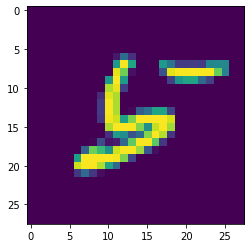

In [202]:
plt.imshow(x_val[91])

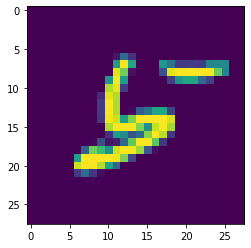

In [203]:
plt.imshow(x_val[91]+r_matrices_16[15,91,4,:,:])

In [204]:
y_val[91]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

In [145]:
def get_perturbations(m, multiplier=1):
    y_perturbed = y_val.numpy()
    x_perturbed = x_val.numpy()
    remove_indices = []
    distortion = 0
    for i in range(val_size):
        if sum(r_norms[m,i,:]) >= 1e7:
            remove_indices.append(i)
        else:
            k = np.argmin(r_norms[m,i,:])
            x_perturbed[i] = x_perturbed[i] + r_matrices_16[m,i,k,:,:]*multiplier
            distortion += (np.sum(np.multiply(r_matrices_16[m,i,k,:,:], r_matrices_16[m,i,k,:,:]))/784)**0.5
            
    x_perturbed = np.delete(x_perturbed, remove_indices, axis=0)
    y_perturbed = np.delete(y_perturbed, remove_indices, axis=0)
    distortion = distortion / x_perturbed.shape[0]
    return x_perturbed, y_perturbed, distortion

In [147]:
distortions = []
for m in range(16):
    x_perturbed, y_perturbed, distortion = get_perturbations(m)
    distortions.append(distortion)
    print(model_names[m])
    print(x_perturbed.shape)
    print(distortion)
    print('---------------')
np.savetxt('distortions.csv', np.array(distortions))

model_10
(8351, 28, 28)
0.0593779909460685
---------------
model_10_l2_3
(7710, 28, 28)
0.062148993435847295
---------------
model_10_l2_2
(772, 28, 28)
0.001316872849489344
---------------
model_10_l2_1
(1117, 28, 28)
0.0003831459854750663
---------------
model_100_100_10_relu
(6895, 28, 28)
0.05034573498653662
---------------
model_100_100_10_relu_l2_3
(6748, 28, 28)
0.04869280265941889
---------------
model_100_100_10_relu_l2_2
(8929, 28, 28)
0.07108349273440065
---------------
model_100_100_10_relu_l2_1
(863, 28, 28)
0.0005807538911293781
---------------
model_200_200_10_relu
(7315, 28, 28)
0.05568597814738444
---------------
model_200_200_10_relu_l2_3
(7601, 28, 28)
0.05613104089074708
---------------
model_200_200_10_relu_l2_2
(8721, 28, 28)
0.07419748740833922
---------------
model_200_200_10_relu_l2_1
(669, 28, 28)
0.0006460623718374734
---------------
model_1200_1200_10_relu
(8248, 28, 28)
0.06935490155309204
---------------
model_1200_1200_10_relu_l2_3
(8248, 28, 28)
0.070818

Functions for running Bayesian NN models

In [208]:
# MODEL_BAYESIAN = load_model(path+'models/bayes_3_0/')
'''
When calling these functions, need to define global variable MODEL_BAYESIAN
'''

def call_model_bayesian(x, eval_samples=1, num_classes=num_classes):
    pred_list = tf.constant(tf.zeros((1, x.shape[0], num_classes)))
    pred_list, x_, s_, i_ = tf.while_loop(cond_eval_samples,
                                        body_eval_samples, 
                                        loop_vars=[pred_list, x, 
                                                    eval_samples, 0],
                                        shape_invariants=[tf.TensorShape([None, x.shape[0], num_classes]), 
                                                            x.shape,
                                                            tf.TensorShape([]),
                                                            tf.TensorShape([])])
    pred_list = tf.gather(pred_list, list(range(1, eval_samples+1)))
    pred_value = tf.reduce_mean(pred_list, axis=0)

    return pred_value

def evaluate_bayesian(x, y, eval_samples=1):
    # 100/eval_samples had better be an integer
    
    metric = CategoricalAccuracy()
    
    acc_list = []
    for s in range(int(100/eval_samples)):
        pred_value = call_model_bayesian(x, eval_samples)
        metric.update_state(y, pred_value)
        acc = metric.result()
        metric.reset_states()
        acc_list.append(float(acc))
        
    accuracy = np.mean(acc_list)
    
    return accuracy

def body_eval_samples(pred_list, x, eval_samples, i):
    logits = MODEL_BAYESIAN(x)
    pred_value = softmax(logits)
    pred_list = tf.concat([pred_list, [pred_value]], axis=0)
    i = i + 1
    return pred_list, x, eval_samples, i

def cond_eval_samples(pred_list, x, eval_samples, i):
    return i < eval_samples

    

## Validation and Test Accuracy

In [209]:
val_acc = []
for m in range(16):
    print(model_names[m])
    lst = models[m].evaluate(x_val, y_val)
    val_acc.append(lst[1])
for m in range(len(bayes_models)):
    MODEL_BAYESIAN = bayes_models[m]
    acc = evaluate_bayesian(x_val, y_val)
    val_acc.append(acc)
    print("Bayesian NN validation accuracy: %.4f" % (acc,))
    
np.savetxt('val_acc.csv', np.array(val_acc))

model_10
313/313 [==============================] - 0s 865us/step - loss: 0.2585 - categorical_accuracy: 0.9310
model_10_l2_3
313/313 [==============================] - 0s 713us/step - loss: 0.2607 - categorical_accuracy: 0.9298
model_10_l2_2
313/313 [==============================] - 0s 861us/step - loss: 0.3084 - categorical_accuracy: 0.9267
model_10_l2_1
313/313 [==============================] - 0s 993us/step - loss: 0.8538 - categorical_accuracy: 0.8891
model_100_100_10_relu
313/313 [==============================] - 0s 1ms/step - loss: 0.0969 - categorical_accuracy: 0.9757
model_100_100_10_relu_l2_3
313/313 [==============================] - 0s 1ms/step - loss: 0.1067 - categorical_accuracy: 0.9762
model_100_100_10_relu_l2_2
313/313 [==============================] - 1s 2ms/step - loss: 0.1279 - categorical_accuracy: 0.9780
model_100_100_10_relu_l2_1
313/313 [==============================] - 0s 1ms/step - loss: 0.8775 - categorical_accuracy: 0.9144
model_200_200_10_relu
313/313 

In [211]:
test_acc = []
for m in range(16):
    print(model_names[m])
    lst = models[m].evaluate(x_test, y_test)
    test_acc.append(lst[1])
for m in range(len(bayes_models)):
    MODEL_BAYESIAN = bayes_models[m]
    acc = evaluate_bayesian(x_test, y_test)
    test_acc.append(acc)
    print("Bayesian NN test accuracy: %.4f" % (acc,))
    
np.savetxt('test_acc.csv', np.array(test_acc))

model_10
313/313 [==============================] - 0s 904us/step - loss: 0.2670 - categorical_accuracy: 0.9261
model_10_l2_3
313/313 [==============================] - 0s 788us/step - loss: 0.2685 - categorical_accuracy: 0.9258
model_10_l2_2
313/313 [==============================] - 0s 791us/step - loss: 0.3165 - categorical_accuracy: 0.9234
model_10_l2_1
313/313 [==============================] - 0s 1ms/step - loss: 0.8650 - categorical_accuracy: 0.8875
model_100_100_10_relu
313/313 [==============================] - 0s 1ms/step - loss: 0.0954 - categorical_accuracy: 0.9757
model_100_100_10_relu_l2_3
313/313 [==============================] - 0s 1ms/step - loss: 0.0994 - categorical_accuracy: 0.9764
model_100_100_10_relu_l2_2
313/313 [==============================] - 0s 1ms/step - loss: 0.1196 - categorical_accuracy: 0.9794
model_100_100_10_relu_l2_1
313/313 [==============================] - 0s 951us/step - loss: 0.8847 - categorical_accuracy: 0.9091
model_200_200_10_relu
313/313 

## Accuracy on Perturbed Data

In [86]:
multiplier = 3

df = pd.DataFrame()
df['names'] = model_names
distortion_list = []
for i in range(16):
    df[model_names[i]] = 0.
for i in range(16):
    print(model_names[i])
    x_perturbed, y_perturbed, distortion = get_perturbations(i, multiplier)
    distortion_list.append(distortion)
    for j in range(16):
        lst = models[j].evaluate(x_perturbed, y_perturbed)
        df.iloc[i, j+1] = lst[1]
        

model_10
261/261 [==============================] - 0s 1ms/step - loss: 1.3326 - categorical_accuracy: 0.7682
model_10_l2_3
241/241 [==============================] - 0s 1ms/step - loss: 1.4205 - categorical_accuracy: 0.7274
model_10_l2_2
25/25 [==============================] - 0s 1ms/step - loss: 2.3957 - categorical_accuracy: 0.2137
model_10_l2_1
35/35 [==============================] - 0s 1ms/step - loss: 2.1308 - categorical_accuracy: 0.3384
model_1200_1200_10_relu
258/258 [==============================] - 0s 1ms/step - loss: 1.4860 - categorical_accuracy: 0.6216
model_1200_1200_10_relu_l2_3
258/258 [==============================] - 0s 1ms/step - loss: 1.5052 - categorical_accuracy: 0.6130
model_1200_1200_10_relu_l2_2
246/246 [==============================] - 0s 2ms/step - loss: 1.8524 - categorical_accuracy: 0.4286
model_1200_1200_10_relu_l2_1
11/11 [==============================] - 0s 1ms/step - loss: 2.9578 - categorical_accuracy: 0.0944
model_200_200_10_relu
229/229 [=====

238/238 [==============================] - 0s 2ms/step - loss: 1.2885 - categorical_accuracy: 0.7431
model_200_200_10_relu_l2_2
273/273 [==============================] - 0s 2ms/step - loss: 1.5382 - categorical_accuracy: 0.6003
model_200_200_10_relu_l2_1
21/21 [==============================] - 0s 2ms/step - loss: 2.6168 - categorical_accuracy: 0.0747
model_100_100_10_relu
216/216 [==============================] - 0s 1ms/step - loss: 1.2785 - categorical_accuracy: 0.7530
model_100_100_10_relu_l2_3
211/211 [==============================] - 1s 3ms/step - loss: 1.2708 - categorical_accuracy: 0.7558
model_100_100_10_relu_l2_2
280/280 [==============================] - 0s 2ms/step - loss: 1.4877 - categorical_accuracy: 0.6182
model_100_100_10_relu_l2_1
27/27 [==============================] - 0s 1ms/step - loss: 2.4475 - categorical_accuracy: 0.0000e+00


In [158]:
df
# df.to_csv('models_r_3_0.csv')

,names,model_10,model_10_l2_3,model_10_l2_2,model_10_l2_1,model_1200_1200_10_relu,model_1200_1200_10_relu_l2_3,model_1200_1200_10_relu_l2_2,model_1200_1200_10_relu_l2_1,model_200_200_10_relu,model_200_200_10_relu_l2_3,model_200_200_10_relu_l2_2,model_200_200_10_relu_l2_1,model_100_100_10_relu,model_100_100_10_relu_l2_3,model_100_100_10_relu_l2_2,model_100_100_10_relu_l2_1
0,model_10,0.000000,0.000000,0.011496,0.802539,0.456832,0.477428,0.485810,0.700036,0.489522,0.448689,0.507245,0.786852,0.467728,0.374805,0.418273,0.768171
1,model_10_l2_3,0.000130,0.000000,0.010895,0.787808,0.419066,0.431128,0.436706,0.635798,0.431388,0.404799,0.468093,0.748249,0.430610,0.337484,0.375357,0.727367
2,model_10_l2_2,0.108808,0.097150,0.000000,0.146373,0.797927,0.794041,0.803109,0.589378,0.795337,0.786269,0.800518,0.306995,0.773316,0.766839,0.778497,0.213731
3,model_10_l2_1,0.499552,0.488809,0.430618,0.000000,0.865712,0.863026,0.868397,0.727842,0.855864,0.853178,0.861235,0.472695,0.845121,0.845121,0.849597,0.338406
4,model_1200_1200_10_relu,0.023400,0.026794,0.121484,0.688288,0.000000,0.014549,0.016368,0.327837,0.019520,0.022551,0.024127,0.600024,0.024612,0.022672,0.024733,0.621605
5,model_1200_1200_10_relu_l2_3,0.024127,0.026431,0.119908,0.684530,0.010184,0.000000,0.011518,0.308196,0.017095,0.017944,0.022793,0.581959,0.020369,0.019762,0.022551,0.612997
6,model_1200_1200_10_relu_l2_2,0.010678,0.011440,0.047032,0.592348,0.005339,0.004576,0.000000,0.080336,0.008008,0.007500,0.008262,0.370662,0.008644,0.007754,0.008644,0.428626
7,model_1200_1200_10_relu_l2_1,0.123894,0.112094,0.088496,0.091445,0.539823,0.548673,0.563422,0.000000,0.533923,0.542773,0.542773,0.079646,0.519174,0.507375,0.536873,0.094395
8,model_200_200_10_relu,0.096787,0.102119,0.390704,0.746138,0.127683,0.139850,0.142857,0.646070,0.000000,0.143541,0.144361,0.734792,0.135065,0.123308,0.121668,0.724402
9,model_200_200_10_relu_l2_3,0.114459,0.119984,0.401658,0.765426,0.123536,0.153006,0.155111,0.676227,0.143139,0.000000,0.144981,0.760426,0.147744,0.112222,0.143271,0.743060


Run Bayesian NN

In [215]:
MODEL_BAYESIAN = bayes_models[0]

eval_samples_list = [1]

df_bayes = pd.DataFrame()
df_bayes['names'] = model_names

for j in range(len(eval_samples_list)):
    eval_samples = eval_samples_list[j]
    df_bayes['accuracy with '+str(eval_samples)] = [0. for i in range(16)]
    
    for i in range(16):
        x_perturbed, y_perturbed, distortion = get_perturbations(i, 1.5)

        acc = evaluate_bayesian(x_perturbed, y_perturbed, eval_samples)

        df_bayes.iloc[i,j+1] = float(acc)
    print(np.mean(df_bayes.iloc[:,j+1]))
        

0.8438871340453624


In [216]:
df_bayes

,names,accuracy with 1
0,model_10,0.951397
1,model_10_l2_3,0.946811
2,model_10_l2_2,0.774391
3,model_10_l2_1,0.834843
4,model_100_100_10_relu,0.921983
5,model_100_100_10_relu_l2_3,0.925279
6,model_100_100_10_relu_l2_2,0.888622
7,model_100_100_10_relu_l2_1,0.801564
8,model_200_200_10_relu,0.914085
9,model_200_200_10_relu_l2_3,0.921538


In [217]:
df_bayes.to_csv('bayes_4_0_r_1_5.csv')

## Accuracy under Perturbation and Model Pruning

In [162]:
def prune(w, remove_ratio):
    '''
    Weights pruning.
    This function depends on the knowledge that, model weights follows this format:
    for each layer:
        weight_mu
        bias_mu
        weight_rho
        bias_rho
    '''

    sn_ratio = []
    for i in range(0, len(w), 4):
        sn_ratio.append(w[i]/tf.math.softplus(w[i+2]))
        sn_ratio.append(w[i+1]/tf.math.softplus(w[i+3]))

    sorted_ratio = []
    for i in range(len(sn_ratio)):
        sorted_ratio.append(np.argsort(np.reshape(abs(sn_ratio[i]), (-1,))))

    new_weights = deepcopy(w)
    for i in range(0, len(sorted_ratio), 2):
        remove_until_1 = min(int(len(sorted_ratio[i]) * remove_ratio), (len(sorted_ratio[i])-1))
        remove_until_2 = min(int(len(sorted_ratio[i+1]) * remove_ratio), (len(sorted_ratio[i+1])-1))
        for j in range(remove_until_1):
            rmv_idx = sorted_ratio[i][j]
            idx1 = int(rmv_idx / w[i*2].shape[1])
            idx2 = rmv_idx - idx1 * w[i*2].shape[1]
            new_weights[i*2][idx1, idx2] = 0.0
            new_weights[i*2+2][idx1, idx2] = -100.0
        for j in range(remove_until_2):
            idx = sorted_ratio[i+1][j]
            new_weights[i*2+1][idx] = 0.0
            new_weights[i*2+3][idx] = -100.0
            
    return new_weights

In [236]:
print(bayes_names[5])
MODEL_BAYESIAN = bayes_models[5] # rho initialized to -2
eval_samples = 100

w = MODEL_BAYESIAN.get_weights()
w_archive = deepcopy(w)

df_prune = pd.DataFrame()
df_prune['names'] = model_names
ratios = [0.25,0.5,0.75,0.9,0.95,0.98]

for j in range(len(ratios)):

    w = MODEL_BAYESIAN.get_weights()
    ratio = ratios[j]
    new_w = prune(w, ratio)
    MODEL_BAYESIAN.set_weights(new_w)

    df_prune[str(ratio)] = [0. for i in range(16)]

    for i in range(16):
        x_perturbed, y_perturbed, distortion = get_perturbations(i, 1.5)

        acc = evaluate_bayesian(x_perturbed, y_perturbed, eval_samples)

        df_prune.iloc[i,j+1] = float(acc)

    # acc = evaluate_bayesian(x_test, y_test, eval_samples)

    MODEL_BAYESIAN.set_weights(w_archive)
    
    print(acc)

bayes_2_0
0.48967552185058594
0.48672565817832947
0.4601770043373108
0.4336283206939697
0.3687315583229065
0.2507374584674835


In [237]:
df_prune

,names,0.25,0.5,0.75,0.9,0.95,0.98
0,model_10,0.966351,0.963956,0.962040,0.941803,0.819064,0.538977
1,model_10_l2_3,0.960700,0.961219,0.958236,0.938392,0.810376,0.535019
2,model_10_l2_2,0.759067,0.757772,0.753886,0.713731,0.568653,0.326425
3,model_10_l2_1,0.829006,0.831692,0.824530,0.784244,0.638317,0.359893
4,model_100_100_10_relu,0.946483,0.945468,0.939376,0.908920,0.781871,0.517041
5,model_100_100_10_relu_l2_3,0.949022,0.945762,0.943391,0.904861,0.787937,0.538826
6,model_100_100_10_relu_l2_2,0.927315,0.924068,0.909620,0.851831,0.688655,0.428491
7,model_100_100_10_relu_l2_1,0.789108,0.787949,0.779838,0.743917,0.600232,0.329085
8,model_200_200_10_relu,0.948599,0.946685,0.938893,0.896377,0.755161,0.495967
9,model_200_200_10_relu_l2_3,0.949612,0.948428,0.938298,0.906065,0.764636,0.502829


In [238]:
df_prune.to_csv('prune_2_0_r_1_5_s_100.csv')

Scratches

In [ ]:
weights = np.load(path+'/weights_rho_rnd_2_4.npy', allow_pickle=True).flatten()[0]

nn = Neural_network_numpy(weights)

predictions = nn.predict(np.reshape(x_train[0], (-1,)))
print(predictions)

[ -8.09932945 -21.45716771   3.31232257  22.68672388 -43.33224414
  50.59693345   4.81355797 -13.91471448  11.31174654  11.68219634]


In [ ]:
def loss_fn(y_true, logits, from_logits=True):
    if from_logits:
        logits = np.squeeze(logits)
        y_true = np.squeeze(y_true)
        denom = sum(np.exp(logits))
        y_pred = np.exp(logits)/denom
        true_idx = np.where(np.array(y_true)==1)[0][0]
        return -np.log(y_pred[true_idx])     

In [ ]:
from scipy.optimize import minimize, Bounds

def objective(r, model_numpy, x, y):
    norm = np.linalg.norm(r)
    perturbed_img = np.array([r + np.reshape(x, (-1,))])
    logits = model_numpy.predict(perturbed_img)
    loss_value = loss_fn(y, logits)
    print(r)
    return (norm + loss_value)

minimize(objective, np.zeros((1,784))+2e-3, args=(nn,x_train[0],y_train[0]), method='Nelder-Mead', options={'maxiter':2, 'maxfev':2})

In [ ]:
np.where(np.array([0,0,1])==1)[0][0]

2

In [ ]:
def f(x, a, b):
    if a and b:
        return sum(x**2)
    else:
        return 10

minimize(f, np.array([2,2.5]), args=(1,1), method='L-BFGS-B', bounds=[[0.5, 3],[0,3]])

#np.random.normal(loc=0.5, scale=0.2, size=(img_shape1,img_shape2))